In [1]:
# hack to import modules from outside this folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

import os

import tools
import effect
import player
import sound
import metrics
from env import CrossAdaptiveEnv, DEFAULT_CONFIG, Mode

## Render with source and target (both dry and wet)

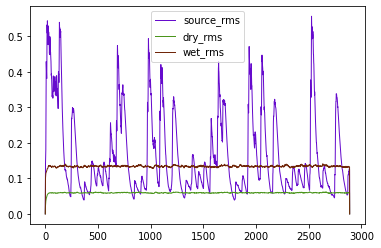

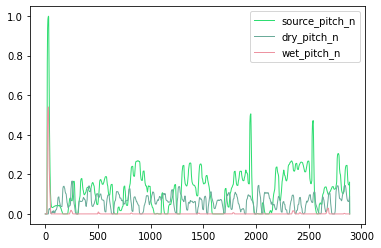

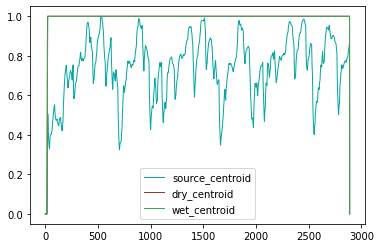

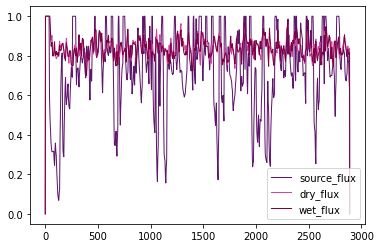

In [3]:
ANALYSIS_CHANNELS = ["rms", "pitch_n", "centroid", "flux"]

source_sound = "amen_trim.wav"
target_sound = "noise.wav" # "amen_trim.wav"

config = {}
config["effect"] = effect.Effect("dist_lpf")
config["metric"] = metrics.EuclideanDistance()
config["mode"] = Mode.STATIC
config["source"] = source_sound
config["target"] = target_sound

# one fixed mapping
env = CrossAdaptiveEnv(config)
action = env.action_space.sample()
mapping = env.action_to_mapping(action)

# source
source_sound = sound.Sound(source_sound, output_file_path="source.wav", loop=False)
source_sound.apply_effect()

# target without effect
dry_sound = sound.Sound(target_sound, output_file_path="dry.wav", loop=False)
dry_sound.apply_effect()

# target with effect
wet_sound = sound.Sound(target_sound, output_file_path="wet.wav", loop=False)
wet_sound.apply_effect(env.effect)

source_features = np.zeros(4)
dry_features = np.zeros(4)
wet_features = np.zeros(4)
    
features = [source_features, dry_features, wet_features]
feature_names = ["source", "dry", "wet"]
sounds = [source_sound, dry_sound, wet_sound]

done = False

while not done:
    # no effect
    done1 = source_sound.render()
    done2 = dry_sound.render()
    
    # apply mapping
    done3 = wet_sound.render(mapping)
    
    _features = []
    for (feature, _sound) in zip(features, sounds):
        feature = np.vstack((feature, _sound.player.get_channels(ANALYSIS_CHANNELS)))
        _features.append(feature)
    features = _features.copy()
    
    '''
    For new random mapping every k
    
    TODO: use some noise generator instead because sounds very distorted
    
    action = env.action_space.sample()
    mapping = env.action_to_mapping(action)
    '''
    
    done = done1 or done2 or done3

for i, channel in enumerate(ANALYSIS_CHANNELS):
    for j, feature in enumerate(features):
        channel_feature = feature[:,i]
        color = np.random.rand(3,)
        plt.plot(channel_feature, c=color, label=f"{feature_names[j]}_{channel}", linewidth=1, markersize=12)
    plt.legend()
    plt.show()

## Bounce sounds

In [4]:
for sound in sounds:
    bounce_path = sound.bounce()
    print(bounce_path)
    # tools.play_wav(bounce_path)

/Users/ulrikah/fag/thesis/rave/rave/bounces/source.wav
/Users/ulrikah/fag/thesis/rave/rave/bounces/dry.wav
/Users/ulrikah/fag/thesis/rave/rave/bounces/wet.wav


# Visualisation of rewards with different metrics

**Using a random effect combination throughout the whole render**

euclid 0.505705158106712 0.4149305567614531 1.0
abs 0.7169134499110187 0.6100890780611782 1.0


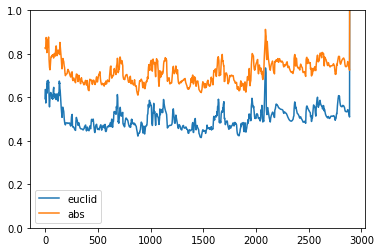

In [15]:
source_sound = "sine220.wav"
target_sound = "amen.wav" # "amen_trim.wav"

_metrics = [("euclid", metrics.EuclideanDistance), ("abs", metrics.AbsoluteValueNorm)]


for metric_name, metric in _metrics:    
    config = {}
    config["effect"] = effect.Effect("dist_lpf")
    config["metric"] = metric()
    config["mode"] = Mode.STATIC
    config["source"] = source_sound
    config["target"] = target_sound

    env = CrossAdaptiveEnv(config)
    action = env.action_space.sample()
    mapping = env.action_to_mapping(action)

    done = False
    rewards = []
    while not done:

        '''
        For new random mapping every k
        '''
        action = env.action_space.sample()
        _, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
    
    np_rewards = np.array(rewards)
    print(metric_name, np_rewards.mean(), np_rewards.min(), np_rewards.max())
    plt.ylim((0, 1))
    plt.plot(rewards, label=metric_name)

plt.legend()
plt.show()